## Imports

In [1]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from helpers.eda import plot_imbalance


teal = '#01ACA5'
purple = '#BF40BF'
sns.set_palette(sns.color_palette([teal, purple]))
white_median = dict(color='yellow')

pd.set_option('display.max_columns', 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
start = time.time()

## Numerical EDA

In [3]:
header = ['age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour',
          'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code',
          'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union',
          'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses',
          'divdends_from_stocks', 'tax_filer_status', 'region_of_previous_residence',
          'state_of_previous_residence', 'detailed_household_and_family_stat',
          'detailed_household_summary_in_household', 'unknown_column', 'migration_code_change_in_msa',
          'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
          'migration_prev_res_in_sunbelt',  'num_persons_worked_for_employer', 'family_members_under_18',
          'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self',
          'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin',
          'veterans_benefits', 'weeks_worked_in_year', 'year', 'taxable_income_amount']

otrain = pd.read_csv('./data/census_income_learn.csv', names=header, sep=', ')
otest = pd.read_csv('./data/census_income_test.csv', names=header, sep=', ')

train = pd.read_csv('./data/census_income_learn.csv', names=header, sep=', ')
test = pd.read_csv('./data/census_income_test.csv', names=header, sep=', ')

In [4]:
len(header)

42

There are 42 columns according to the metadata information.

In [5]:
train.shape

(199523, 42)

There are 199523 observations in the train dataset.

In [6]:
test.shape

(99762, 42)

There are 99762 observations in the train dataset.

### Cleaning

#### Dependent variable to boolean

In [7]:
train.taxable_income_amount.unique()

array(['- 50000.', '50000+.'], dtype=object)

There are two possible values in the dependent variable:  
- individuals earning less than \\$50K per year
- individuals earning more than \\$50K per year

We are going to remap these values. Since our goal is to identify if an individual earns more than \\$50K per year:
- individuals earning less than \\$50K per year will be 0
- individuals earning more than \\$50K per year will be 1

In [8]:
boolean_map = {'- 50000.': 0, 
               '50000+.': 1}

train.taxable_income_amount.replace(boolean_map, inplace=True)

In [9]:
train.taxable_income_amount.unique()

array([0, 1])

#### Certain data leakage

Some quantitative columns contain explicit income value and therefore present a data leakage risk. We will remove these.

In [10]:
train.drop(columns=['wage_per_hour', 'capital_gains', 'capital_losses', 'divdends_from_stocks'], inplace=True)

#### Potential data leakage

There is a quantitative column containing a lot of different values that look like a salary. We have no certainty what this column is, so we drop it.

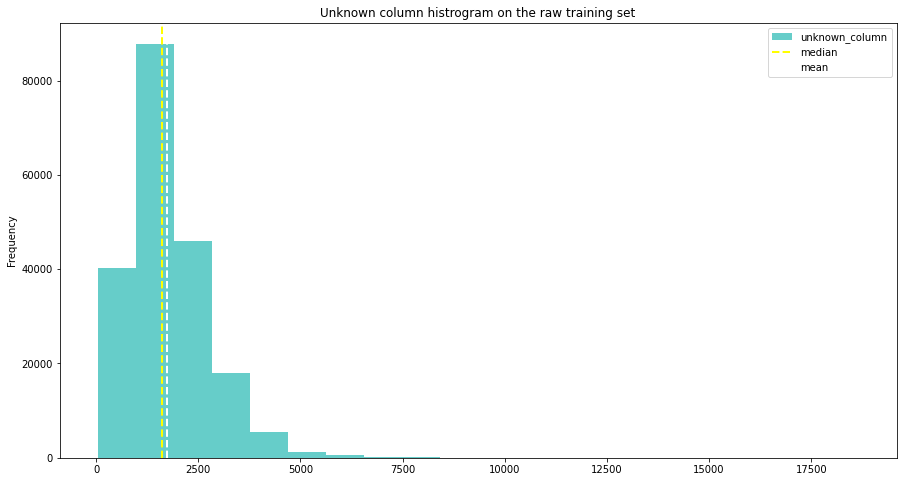

In [11]:
train.unknown_column.plot.hist(bins=20, figsize=(15,8), alpha=0.6)

plt.axvline(train.unknown_column.median(),
            color='yellow',
            linestyle='--',
            linewidth=2,
            label='median')

plt.axvline(train.unknown_column.mean(),
            color='white',
            linestyle='--',
            linewidth=2,
            label='mean')

plt.legend(loc='upper right')
plt.title("Unknown column histrogram on the raw training set")
plt.show()

In [12]:
train.drop(columns=['unknown_column'], inplace=True)

#### Missing values

Some cells have a 'Not in universe.' value: this corresponds to the way missing values are encoded. We will replace these by NaN values, that pandas can handle more efficiently.

In [13]:
train.replace(to_replace='Not in universe.*', value=np.nan, regex=True, inplace=True)

Other missing values were encoded using the '?' character. Again, we will replace these by NaN values, that pandas can handle more efficiently.

In [14]:
train.replace(to_replace='\?', value=np.nan, regex=True, inplace=True)

In [15]:
train.isnull().mean()

age                                          0.000000
class_of_worker                              0.502423
industry_code                                0.000000
occupation_code                              0.000000
education                                    0.000000
enrolled_in_edu_inst_last_wk                 0.936950
marital_status                               0.000000
major_industry_code                          0.504624
major_occupation_code                        0.504624
race                                         0.000000
hispanic_origin                              0.004380
sex                                          0.000000
member_of_a_labor_union                      0.904452
reason_for_unemployment                      0.969577
full_or_part_time_employment_stat            0.000000
tax_filer_status                             0.000000
region_of_previous_residence                 0.920946
state_of_previous_residence                  0.924495
detailed_household_and_famil

There are a few columns with high rates of missing values. We will get rid of any column that displays a missing value ratio greater than 30%.

In [16]:
nan_proportion_by_col = train.isnull().mean()
high_nan_columns = nan_proportion_by_col[nan_proportion_by_col > 0.30].index
len(high_nan_columns)

15

There are a 12 columns with high rates of missing values. We get rid of them.

In [17]:
train.drop(columns=high_nan_columns, inplace=True)

Major industry code and major occupation code are duplicates anyway: they are a less precise version of indsutry code and occupation code.

There are also children in the dataset. Just by looking at the value counts, we see that children are almost always individuals earning less than \\$50K per year. There are only two occurences of individuals lower than 18 earning more than \\$50K. So we get rid of any individual less than 18 years old.

In [18]:
lower_18 = train[train.age < 18]
lower_18.taxable_income_amount.value_counts()

0    55990
1        2
Name: taxable_income_amount, dtype: int64

In [19]:
train = train[train.age >= 18]

There are also people not engaged in the labor force. Among these, only 1% earn more than \\$50K. We can drop this column as well.

In [20]:
not_in_labor = train[train.full_or_part_time_employment_stat == 'Not in labor force']
not_in_labor.taxable_income_amount.value_counts(normalize=True)

0    0.980583
1    0.019417
Name: taxable_income_amount, dtype: float64

In [21]:
train = train[train.full_or_part_time_employment_stat != 'Not in labor force']

##### Duplicate columns

In [22]:
train.industry_code.value_counts()

0     24021
33    15516
43     8145
4      5893
42     4593
45     4420
29     4175
41     3949
37     3931
32     3547
35     3344
39     2858
34     2747
44     2442
2      2056
11     1753
50     1684
47     1636
38     1583
40     1490
24     1442
12     1347
19     1331
30     1172
31     1170
25     1078
9       986
22      945
13      894
36      810
1       778
48      645
27      621
49      604
3       560
6       551
21      551
8       549
5       546
16      534
23      521
18      482
15      450
7       421
14      293
46      182
17      156
28      140
26      126
51       34
20       32
10        4
Name: industry_code, dtype: int64

Major industry code is similar to industry code, just less precise: we drop.

In [23]:
x = train.taxable_income_amount.value_counts(normalize=True).index
y = train.taxable_income_amount.value_counts(normalize=True)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119738 entries, 1 to 199522
Data columns (total 22 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      119738 non-null  int64 
 1   industry_code                            119738 non-null  int64 
 2   occupation_code                          119738 non-null  int64 
 3   education                                119738 non-null  object
 4   marital_status                           119738 non-null  object
 5   race                                     119738 non-null  object
 6   hispanic_origin                          119152 non-null  object
 7   sex                                      119738 non-null  object
 8   full_or_part_time_employment_stat        119738 non-null  object
 9   tax_filer_status                         119738 non-null  object
 10  detailed_household_and_family_stat       119

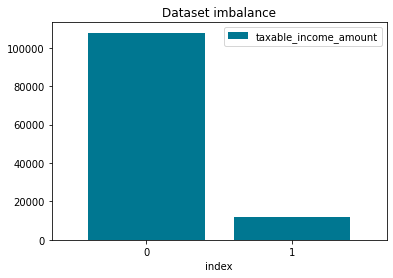

In [25]:
fig = plot_imbalance(train)
plt.show()

In [26]:
end = time.time()
execution = round(end - start)
print(f'Numerical EDA took {execution} seconds to execute.')

Numerical EDA took 47 seconds to execute.
